In [46]:
import urllib
import re
import random
import datetime
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib import pyplot as plt

In [2]:
base_url = 'http://www.1point3acres.com/bbs/forum.php?mod=forumdisplay&fid=82&sortid=164&searchoption[3004][value]=6&searchoption[3004][type]=radio&searchoption[3001][value]=3&searchoption[3001][type]=radio&searchoption[3003][value]=1&searchoption[3003][type]=radio&sortid=164&filter=sortid&page='

In [3]:
def find_school_and_date(base_url, page):
    url = base_url + str(page)
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36HH=14Runtime=lfhglmomfihibpkplgodklnokgbeajfhALICDN/ DOL/HELLO_GWF_s_7460_r2x9ak474125_2'
    headers = {'User-Agent': user_agent}
    request = urllib.request.Request(url, headers = headers)
    response = urllib.request.urlopen(request, timeout=180)
    content = response.read().decode('gb2312', errors='ignore')
    pattern = re.compile('<span style="margin-top: 3px".*?<font color="black"><b>(.*?)</b>.*?@<font.*?>(.*?)</font>.*?<font color="brown">(.*?)</font>.*?</font><font color="brown">',re.S)
    items = re.findall(pattern,content)
    return items

In [4]:
def init():
    my_school_list = ('Stanford', 'CMU', 'Havard', 'Upenn', 'Umich', 'JHU', 'UCSD', 'USC', 'UCLA')
    school_2017_dict_ad_data = {}
    school_2017_dict_rej_data = {}
    for school in my_school_list:
        school_2017_dict_ad_data[school] = []
        school_2017_dict_rej_data[school] = []
    return (my_school_list, school_2017_dict_ad_data, school_2017_dict_rej_data)

In [5]:
def update_dict(my_school_list, school_2017_dict_ad_data, school_2017_dict_rej_data, base_url, page):
    items = find_school_and_date(base_url, page)
    for item in items:
        bool_value = False
        for school in my_school_list:
            if school.lower() in item[1].lower():
                temp_school = school
                bool_value = True
                break
        if ('ad' in item[0].lower() and bool_value):
            school_2017_dict_ad_data[temp_school].append(item[2])
        elif ('rej' in item[0].lower() and bool_value):
            school_2017_dict_rej_data[temp_school].append(item[2])
        elif ('WaitingList'.lower() in item[0].lower() and bool_value):
            continue
        elif bool_value:
            print('This is a problem data: ', item)
    return (school_2017_dict_ad_data, school_2017_dict_rej_data)

In [6]:
def get_all_data():
    (my_school_list, school_2017_dict_ad_data, school_2017_dict_rej_data) = init()
    for i in range(1, 38):
        if i%5 == 0:
            print('processing page: ', i)
        page = i
        try:
            (school_2017_dict_ad_data, school_2017_dict_rej_data) = \
                update_dict(my_school_list, school_2017_dict_ad_data, school_2017_dict_rej_data, base_url, page)
        except:
            print('processing page No.%d error!'%i)
    return (school_2017_dict_ad_data, school_2017_dict_rej_data)

In [7]:
(school_2017_dict_ad_data, school_2017_dict_rej_data) = get_all_data()

processing page:  5
processing page:  10
processing page No.13 error!
processing page:  15
processing page:  20
This is a problem data:  ('Offer', 'Stanford University', '2017-02-27')
processing page:  25
processing page:  30
processing page No.30 error!
processing page:  35
This is a problem data:  ('Offer', 'ee@usc', '2016-11-24')


### Processing Some Error Pages

In [12]:
my_school_list = ('Stanford', 'CMU', 'Havard', 'Upenn', 'Umich', 'JHU', 'UCSD', 'USC', 'UCLA')
(school_2017_dict_ad_data, school_2017_dict_rej_data) = update_dict(my_school_list, school_2017_dict_ad_data, school_2017_dict_rej_data, base_url, 30)

In [143]:
def check_sign(sign, item, list_data):
    if sign in item:
        if item in list_data:
            list_data.remove(item)
        sets = item.split(sign)
        if len(sets) == 3:
            item = item.replace(sign, '-')
            list_data.append(item)
        return list_data
    else:
        if '-' not in item:
            if item in list_data:
                list_data.remove(item)
        elif ('-' in item and len(item.split('-')) != 3):
            if item in list_data:
                list_data.remove(item)
        return list_data

def format_check(list_data):
    for item in list_data:
        list_data = check_sign('.', item, list_data)
        list_data = check_sign('/', item, list_data)
    return list_data

In [144]:
def date_valid(list_data):
    for item in list_data:
        sets = item.split('-')
        year = sets[0]
        month = sets[1]
        if int(year) == 2016 and int(month) < 10:
            list_data.remove(item)
        elif int(year) !=2016 and int(year) != 2017:
            list_data.remove(item)
    return list_data

In [145]:
def plot_one_school(data, school_name, ad_or_rej):
    temp_list = data[school_name]
    temp_list = format_check(temp_list)
    temp_list = date_valid(temp_list)
    temp_list.sort(key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    date_list = [datetime.date(int(item.split('-')[0]),int(item.split('-')[1]), int(item.split('-')[2])) for item in temp_list]
    # print(date_list)
    plt.hist(date_list, 50, facecolor='green')
    # plt.gcf().autofmt_xdate()
    formatter = DateFormatter('%Y-%m')
    plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
    plt.xlabel('date (year-month)')
    plt.ylabel('number of results')
    plt.title(ad_or_rej + ' of ' + school_name + ' in 2017')
    plt.show()

In [162]:
def plot_all_together(data, ad_or_rej):
    plt.figure(figsize=(22,15))
    i = 1
    for school_name in data.keys():
        # print(school_name)
        plt.subplot(3, 3, i)
        temp_list = data[school_name]
        temp_list = format_check(temp_list)
        temp_list = date_valid(temp_list)
        temp_list.sort(key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
        date_list = [datetime.date(int(item.split('-')[0]),int(item.split('-')[1]), int(item.split('-')[2])) for item in temp_list]
        # print(date_list)
        plt.hist(date_list, 50, facecolor='green')
        # plt.gcf().autofmt_xdate()
        formatter = DateFormatter('%Y-%m')
        plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
        plt.xlabel('date (year-month)')
        plt.ylabel('number of results')
        plt.title(ad_or_rej + ' of ' + school_name + ' in 2017')
        i += 1
    
    plt.show()
    plt.savefig(ad_or_rej + ' of 2017.png')

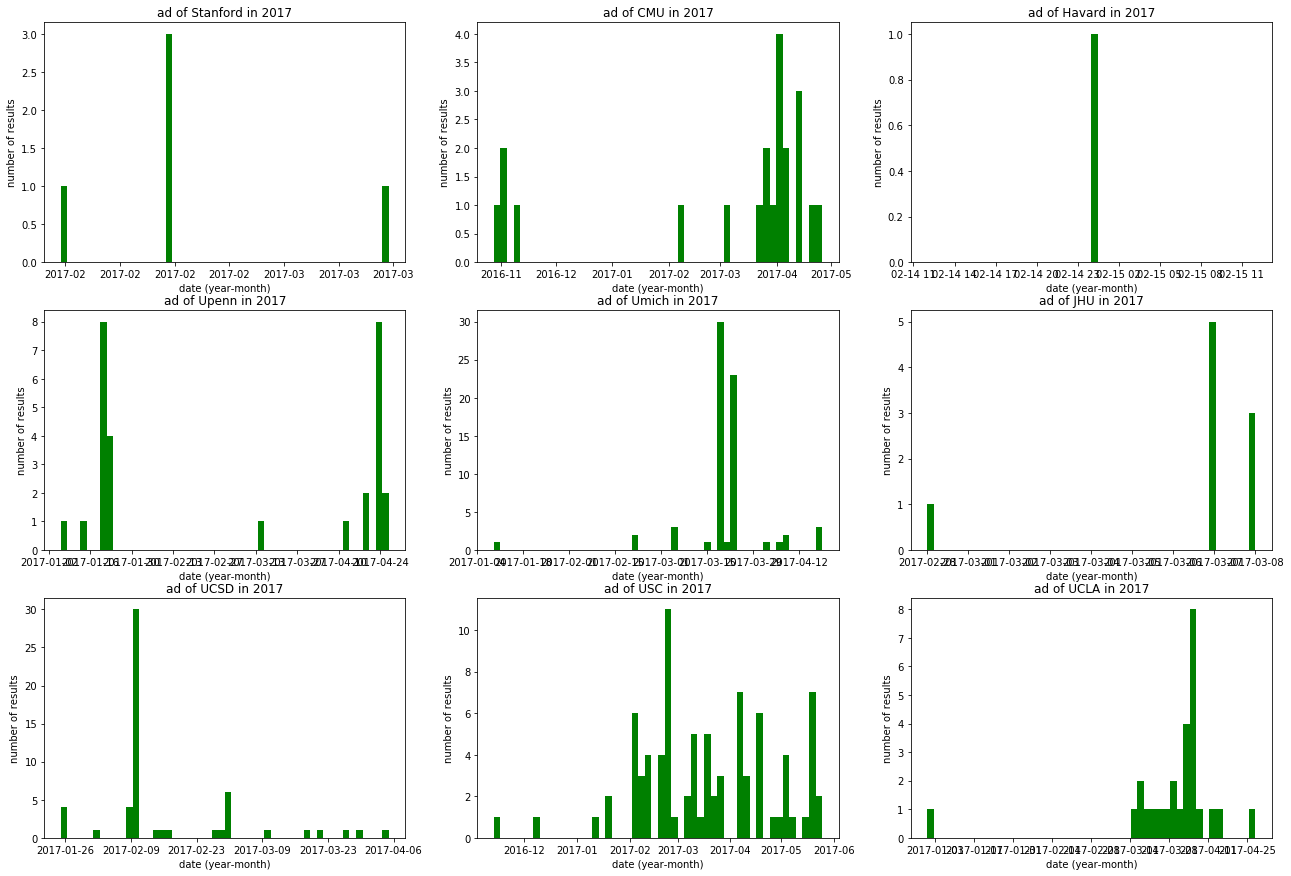

In [163]:
plot_all_together(school_2017_dict_ad_data, 'ad')

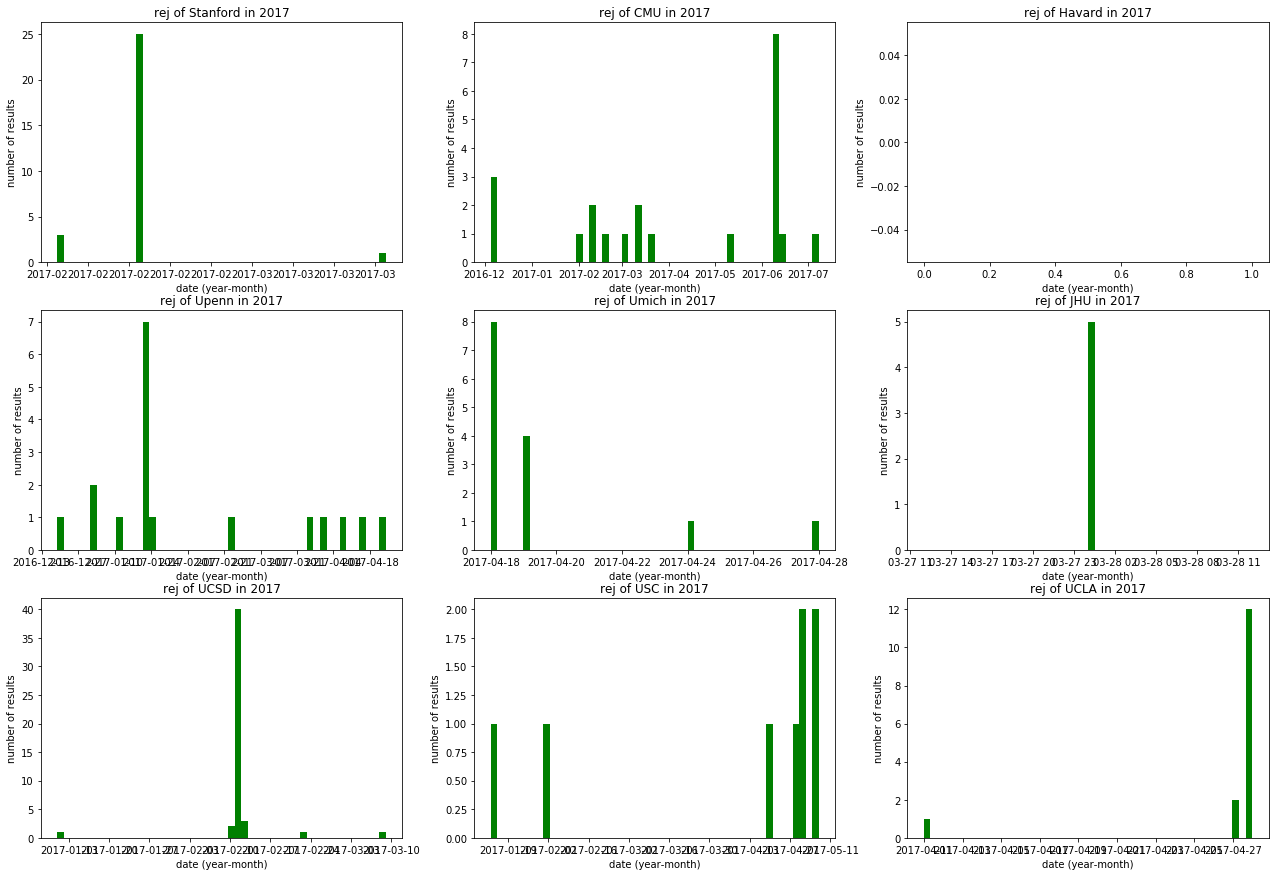

In [164]:
plot_all_together(school_2017_dict_rej_data, 'rej')

#### my_school_list = ('Stanford', 'CMU', 'Havard', 'Upenn', 'Umich', 'JHU', 'UCSD', 'USC', 'UCLA')

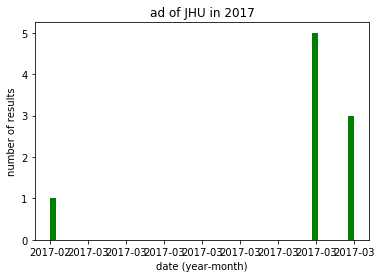

In [121]:
plot_one_school(school_2017_dict_ad_data, 'JHU', 'ad')

### Save Results in TXT

In [156]:
def save_dict(result_dict, file_name):
    with open(file_name, 'w') as f:
        for name in result_dict.keys():
            f.write(name + '\t')
            for info in result_dict[name]:
                f.write(info + '\t')
            f.write('\n')
save_dict(school_2017_dict_ad_data, '2017_ad.txt')
save_dict(school_2017_dict_rej_data, '2017_rej.txt')